<a href="https://colab.research.google.com/github/dudesparsh/Applied-ML/blob/master/Movielens_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Checking GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12159125305971665154, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3067840951437692338
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17669691333978754221
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14912199066
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6720207050307433073
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
# Importing libraries
from fastai.collab import *
from fastai.tabular import *


In [0]:
# Collaborative filtering example

user,item,title = 'userId','movieId','title'


In [49]:
# Untar : Downloading the dataset
path = untar_data(URLs.ML_SAMPLE)
path


PosixPath('/content/datas/movie_lens_sample')

In [48]:
pwd

'/content'

In [50]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()


,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [0]:
data = CollabDataBunch.from_df(ratings, seed=42)


In [0]:
y_range = [0,5.5]


In [0]:
learn = collab_learner(data, n_factors=50, y_range = y_range)

In [54]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.610561,0.903466,00:00
1,0.851748,0.676156,00:00
2,0.659838,0.673052,00:00


In [46]:
# Setting final path for working, not using root since it does not allow you to acces and view all files
mkdir datas
path1 = Path('/content/datas')
path1

PosixPath('/content/datas')

In [63]:
# Using Movielens 100k
# Dataset link
# http://files.grouplens.org/datasets/movielens/ml-100k.zip

!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip && unzip -qq ml-100k.zip -d datas/

--2020-02-08 17:17:43--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  27.2MB/s    in 0.2s    

2020-02-08 17:17:43 (27.2 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [0]:
# The above dataset is downloaded in the folder ml-100k
# and all the work willl be continued in this folder only
path1 = Path('/content/datas/ml-100k')


In [67]:
ratings = pd.read_csv(path1/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()


,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [68]:
movies = pd.read_csv(path1/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()


,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [69]:
len(ratings)

100000

In [70]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed =42, valid_pct =0.1, item_name=title)

In [73]:
data.show_batch()

userId,title,target
474,Raise the Red Lantern (1991),4.0
279,Tombstone (1993),3.0
843,"Fugitive, The (1993)",2.0
500,Manhattan (1979),4.0
99,Four Rooms (1995),3.0


In [0]:
y_range = [0, 5.5]

In [0]:
learn = collab_learner(data, n_factors=40, y_range = y_range, wd =1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


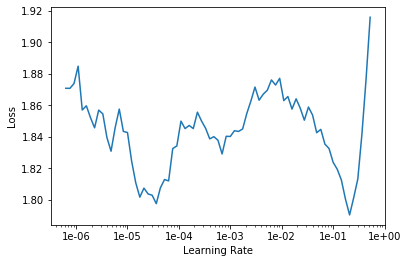

In [76]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [77]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.936711,0.941159,00:10
1,0.845564,0.875578,00:10
2,0.765887,0.834770,00:11
3,0.680779,0.811143,00:10
4,0.541870,0.811205,00:11


In [0]:
learn.save('dotprod')

# Interpretation

In [0]:
learn.load('dotprod');

In [80]:
learn.model
# Embedding is one instance of some array ( one row )

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [81]:
# Getting the Top 10 rated movies
g =rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

## Movie BIAS

In [82]:
movie_bias  = learn.bias(top_movies, is_item = True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [88]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3456),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3089), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2978),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2758), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2680), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2533), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2437), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2161), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2131), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2121), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2076), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2070), 'Jungle2Jungle (1997)', 2.4393939393939394),
 (tensor(-0.2038), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.2035), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2032), 'Island of Dr. Moreau, The (1996)', 2.157894736

In [89]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]


[(tensor(0.5748), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5538), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5533), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5430), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5405), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5399), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5243), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5027), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4958), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4839), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4820), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4795), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4752), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4682), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4655), 'Close Shave, A (1995)', 4.491071428571429)]

## Movie Weights

In [90]:
movie_w = learn.weight(top_movies, is_item = True)
movie_w.shape

torch.Size([1000, 40])

In [91]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]


In [94]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(tensor(1.1507), 'Close Shave, A (1995)'),
 (tensor(1.1399), 'Casablanca (1942)'),
 (tensor(1.0951), 'Wrong Trousers, The (1993)'),
 (tensor(1.0477), 'When We Were Kings (1996)'),
 (tensor(1.0232), 'Chinatown (1974)'),
 (tensor(0.9961), 'Citizen Kane (1941)'),
 (tensor(0.9843), '12 Angry Men (1957)'),
 (tensor(0.9752), 'Lawrence of Arabia (1962)'),
 (tensor(0.9734),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9671), 'Persuasion (1995)')]

In [95]:
sorted(movie_comp, key=itemgetter(0))[:10]


[(tensor(-1.2414), 'Leave It to Beaver (1997)'),
 (tensor(-1.2146), 'Jungle2Jungle (1997)'),
 (tensor(-1.2051), "McHale's Navy (1997)"),
 (tensor(-1.2047), 'Home Alone 3 (1997)'),
 (tensor(-1.1363), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.1185), 'Batman & Robin (1997)'),
 (tensor(-1.0923), 'Congo (1995)'),
 (tensor(-1.0845), 'Bio-Dome (1996)'),
 (tensor(-1.0731), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.0624), 'Mortal Kombat: Annihilation (1997)')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]


In [97]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]


[(tensor(0.8955), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8286), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7933), 'Lost Highway (1997)'),
 (tensor(0.7816), 'Keys to Tulsa (1997)'),
 (tensor(0.7610), 'Dead Man (1995)'),
 (tensor(0.7465), 'Trainspotting (1996)'),
 (tensor(0.7463), 'Very Brady Sequel, A (1996)'),
 (tensor(0.7395), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7373), 'Showgirls (1995)'),
 (tensor(0.7368), 'Jude (1996)')]

In [98]:
sorted(movie_comp, key=itemgetter(0))[:10]


[(tensor(-1.1894), 'Braveheart (1995)'),
 (tensor(-1.1217), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.0515), 'Titanic (1997)'),
 (tensor(-0.8593), "Mr. Holland's Opus (1995)"),
 (tensor(-0.8372), 'Star Wars (1977)'),
 (tensor(-0.8367), 'Return of the Jedi (1983)'),
 (tensor(-0.8324), 'Forrest Gump (1994)'),
 (tensor(-0.8321), 'Hunt for Red October, The (1990)'),
 (tensor(-0.8206), 'True Lies (1994)'),
 (tensor(-0.8184), 'Back to the Future (1985)')]

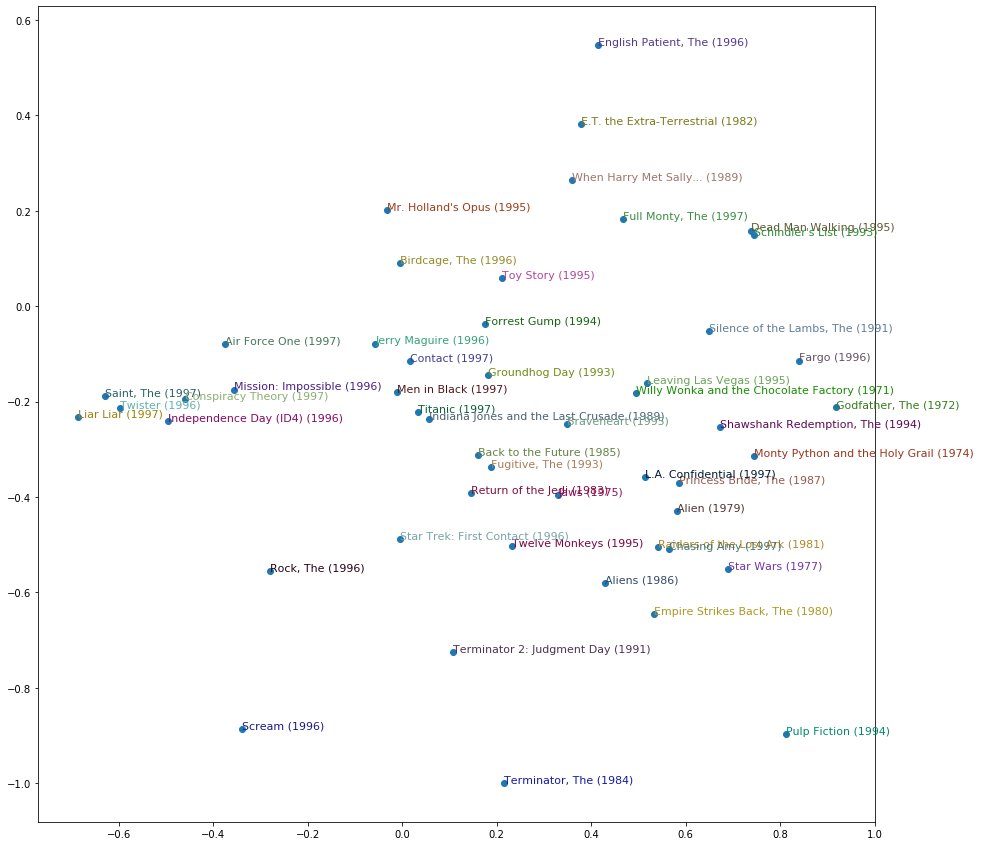

In [99]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()
